# Cluster Installations

In [ ]:
!pip install -q kaggle

# Upload Kaggle API Key
Upload and move kaggle API key to the "/root/.config/kaggle" directory and give it executable permissions

In [ ]:
# Upload kaggle developer API key (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityasabu","key":"ce50f17c90caaf427d2004c144f88090"}'}

In [ ]:
!mkdir /root/.config/kaggle/
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle/’: File exists


# Dataset Retrievals
Download all of the kaggle datasets to be used to train the model

In [ ]:
!kaggle datasets download -d devildyno/email-spam-or-not-classification -p /content
!unzip /content/email-spam-or-not-classification.zip -d /content

!kaggle datasets download -d meruvulikith/190k-spam-ham-email-dataset-for-classification -p /content
!unzip /content/190k-spam-ham-email-dataset-for-classification.zip -d /content

!kaggle datasets download -d yasserh/spamemailsdataset -p /content
!unzip /content/spamemailsdataset.zip -d /content

!kaggle datasets download -d venky73/spam-mails-dataset -p /content
!unzip /content/spam-mails-dataset.zip -d /content

!kaggle datasets download -d ozlerhakan/spam-or-not-spam-dataset -p /content
!unzip /content/spam-or-not-spam-dataset.zip -d /content

!kaggle datasets download -d tapakah68/email-spam-classification -p /content
!unzip /content/email-spam-classification.zip -d /content

!kaggle datasets download -d mohinurabdurahimova/maildataset -p /content
!unzip /content/maildataset.zip -d /content




Dataset URL: https://www.kaggle.com/datasets/devildyno/email-spam-or-not-classification
License(s): CC0-1.0
  0% 0.00/50.8k [00:00<?, ?B/s]
100% 50.8k/50.8k [00:00<00:00, 279MB/s]
Archive:  /content/email-spam-or-not-classification.zip
  inflating: /content/spam_dataset.csv  
Dataset URL: https://www.kaggle.com/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification
License(s): MIT
  0% 0.00/107M [00:00<?, ?B/s]
100% 107M/107M [00:00<00:00, 3.05GB/s]
Archive:  /content/190k-spam-ham-email-dataset-for-classification.zip
  inflating: /content/spam_Emails_data.csv  
Dataset URL: https://www.kaggle.com/datasets/yasserh/spamemailsdataset
License(s): CC0-1.0
  0% 0.00/127k [00:00<?, ?B/s]
100% 127k/127k [00:00<00:00, 559MB/s]
Archive:  /content/spamemailsdataset.zip
  inflating: /content/Spam.csv       
Dataset URL: https://www.kaggle.com/datasets/venky73/spam-mails-dataset
License(s): CC0-1.0
  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 1.48GB/s]
Archive:  /co

# Library Installations
Install all libraries used for model creation and visualization

In [ ]:
# Install all libraries
import os
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras_nlp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [ ]:
# Save datasets as a pandas DataFrame
df_1 = pd.read_csv("/content/spam_ham_dataset.csv")
df_2 = pd.read_csv("/content/spam_Emails_data.csv")
df_3 = pd.read_csv("/content/spam_dataset.csv")
df_4 = pd.read_csv('/content/mail_data.csv')
df_5 = pd.read_csv('/content/email_spam.csv')


In [ ]:
def clean_df(df, spam_values=None, not_spam_values=None):
  """
  Clean and normalize a raw DataFrame for binary spam classification.

  This function
    1) Automatically detects the text and label columns in a
       DataFrame
    2) Standardizes them to a common schema(`text`, `label`)
    3) Normalizes labels to binary values (1 = spam,0 = not spam)
    4) Applies basic text preprocessing.

  Rows with unknown or invalid labels are removed.


  Parameters
  ----------
  df : pandas.DataFrame
      Input DataFrame containing raw text data and corresponding labels.

  spam_values : list, optional
      List of values that should be interpreted as spam labels.
      Values are compared in a case-insensitive manner after string
      conversion. Defaults include common representations such as
      ["spam", "1", 1, True, "yes", "true", "positive"].

  not_spam_values : list, optional
      List of values that should be interpreted as non-spam (ham) labels.
      Values are compared in a case-insensitive manner after string
      conversion. Defaults include common representations such as
      ["ham", "0", 0, False, "no", "false", "negative", "not spam"].

  Returns
  -------
  pandas.DataFrame
      A cleaned DataFrame with two columns:
      - `text`  : Preprocessed text data (lowercased, URLs and punctuation removed)
      - `label` : Integer binary labels (1 = spam, 0 = not spam)

  Rows with unrecognized labels are excluded, and the index is reset.

  """
  # Normalize column names
  df.columns = [str(c).lower() for c in df.columns]

  # Detect text column
  obj_cols = df.select_dtypes(include="object").columns.tolist()
  if obj_cols:
      # Choose the column with longest average string length
      text_col = df[obj_cols].apply(lambda x: x.str.len().mean()).idxmax()
  else:
      # fallback: take first column
      text_col = df.columns[0]

  # Detect label column: pick column with fewest unique values excluding text_col
  possible_label_cols = [c for c in df.columns if c != text_col]
  if possible_label_cols:
      label_col = df[possible_label_cols].nunique().idxmin()
  else:
      # fallback: second column or the same as text
      label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

  # Select and rename
  df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
  df["text"] = df["text"].astype(str)

  # Default spam/ham values
  if spam_values is None:
      spam_values = ["spam", "1", 1, True, "yes", "true", "positive"]
  if not_spam_values is None:
      not_spam_values = ["ham", "0", 0, False, "no", "false", "negative", "not spam"]

  # Normalize labels
  df["label"] = df["label"].astype(str).str.lower().map(
      lambda x: 1 if x in [str(v).lower() for v in spam_values]
      else (0 if x in [str(v).lower() for v in not_spam_values] else None)
  )

  # Drop unknown labels
  df = df.dropna(subset=["label"])
  df["label"] = df["label"].astype(int)

  # Clean text
  def clean_text(t):
      t = t.lower()
      t = re.sub(r"http\S+|www\S+", " ", t)
      t = re.sub(r"[^a-z0-9\s]", " ", t)
      t = re.sub(r"\s+", " ", t).strip()
      return t

  df["text"] = df["text"].apply(clean_text)

  return df.reset_index(drop=True)

In [ ]:
# Run the preprocessing on each of the input datasets
df_1 = clean_df(df_1)
df_2 = clean_df(df_2)
df_3 = clean_df(df_3)
df_4 = clean_df(df_4)
df_5 = clean_df(df_5)

In [ ]:
# Concatenate each of the 5 input datasets
all_dfs = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)

print(all_dfs["label"].value_counts())

label
0    111215
1     94464
Name: count, dtype: int64


In [ ]:
# Separate all spam samples
df_spam = all_dfs[all_dfs["label"] == 1]

# Separate all non-spam samples
df_not_spam = all_dfs[all_dfs["label"] == 0]

# Randomly downsample the non-spam class to match the number of spam samples
df_not_spam_sample = df_not_spam.sample(n=len(df_spam), random_state=42)

# Combine the spam samples and the downsampled non-spam samples into a DataFrame
final_df = pd.concat([df_spam, df_not_spam_sample], ignore_index=True)

print(final_df["label"].value_counts())

label
1    94464
0    94464
Name: count, dtype: int64


In [ ]:
# Rename the "label" column to "is_spam"
final_df = final_df.rename(columns={'label': 'is_spam'})
final_df.head()

,text,is_spam
0,subject photoshop windows office cheap main tr...,1
1,subject looking for medication we re the best ...,1
2,subject vocable rnd word asceticism vcsc brand...,1
3,subject report 01405 wffur attion brom est ins...,1
4,subject vic odin n ow berne hotbox carnal brid...,1


# Model Creation

In [ ]:
# Set variables used in BERT model creation
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

PRESET = "bert_tiny_en_uncased"
SEQ_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 3e-5

In [ ]:
def chunk_text_by_words(text, max_words=120):
    """
    Split a text string into contiguous word-based chunks.

    This function divides a long input string into smaller substrings,
    where each chunk contains at most `max_words` words. Chunking is
    performed sequentially without overlap and preserves the original
    word order.

    Parameters
    ----------
    text : str
        Input text to be split into word-based chunks. The text is
        tokenized using whitespace.

    max_words : int, optional
        Maximum number of words allowed per chunk. Defaults to 120.

    Returns
    -------
    list: list(str)
        A list of text chunks, each containing at most `max_words` words.
        Returns an empty list if the input text is empty or contains no
        valid words.
    """
    words = text.split()
    if not words:
        return []
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = " ".join(words[i:i + max_words])
        chunks.append(chunk)
    return chunks


In [ ]:
def make_ds(text_series, label_series, batch_size=32, shuffle=False):
  """
  Build a TensorFlow `tf.data.Dataset` from raw text and label series.

  This function converts raw text and corresponding labels into a
  batched and prefetched `tf.data.Dataset` suitable for training or
  evaluating a TensorFlow/Keras model. The dataset applies a text
  preprocessing function that maps raw strings to tokenized model
  inputs and pairs them with integer labels.

  Parameters
  ----------
  text_series : pandas.Series
      Series containing raw text strings.

  label_series : pandas.Series
      Series containing integer class labels corresponding to the
      input text. Labels are cast to int32.

  batch_size : int, optional
      Number of samples per batch. Defaults to 32.

  shuffle : bool, optional
      Whether to shuffle the dataset before batching. Shuffling uses
      the full dataset size as the buffer and is reproducible via a
      fixed random seed. Defaults to False.

  Returns
  -------
  tf.data.Dataset
      A TensorFlow dataset yielding `(inputs, label)` pairs, where
      `inputs` is the output of the preprocessing function (e.g.,
      token IDs, segment IDs, and attention masks) and `label` is an
      integer class label.
  """
  # Convert pandas Series to NumPy arrays for TensorFlow compatibility
  texts = text_series.to_numpy()
  labels = label_series.to_numpy().astype("int32")

  # Create a TensorFlow dataset from (text, label) pairs
  ds = tf.data.Dataset.from_tensor_slices((texts, labels))
  if shuffle:
      ds = ds.shuffle(buffer_size=len(texts), seed=SEED,
                      reshuffle_each_iteration=True)

  # Map preprocessor on raw string → token dict (token_ids, segment_ids, padding_mask)
  ds = ds.map(
      lambda x, y: (preproc(tf.cast(x, tf.string)), y),
      num_parallel_calls=tf.data.AUTOTUNE,
  )

  # Batch the dataset and prefetch batches to overlap data loading and training
  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
def predict_long_email(model, text, max_words=120, threshold=0.5, agg="max"):
    """
    Predict spam or non-spam for a potentially long email by chunking the text.

    This function handles inputs that exceed typical transformer token limits
    by splitting the email text into word-based chunks, running the model on
    each chunk independently, and aggregating the chunk-level predictions into
    a single overall prediction.

    Parameters
    ----------
    model : tf.keras.Model
        A trained TensorFlow/Keras model that accepts raw text strings and
        outputs a spam probability for each input sample.

    text : str
        The full email or message text to be classified.

    max_words : int, optional
        Maximum number of words per chunk. Defaults to 120.

    threshold : float, optional
        Probability threshold used to convert the aggregated spam probability
        into a binary label. Defaults to 0.5.

    agg : {"max", "mean"}, optional
        Aggregation strategy used to combine chunk-level probabilities:
        - "max": Uses the maximum chunk probability (flags spam if any chunk is spam-like)
        - "mean": Uses the average chunk probability across all chunks
        - Defaults to "max".

    Returns
    -------
    dict
        Dictionary containing detailed prediction results:
        - "chunks"        : List of text chunks evaluated by the model
        - "chunk_probs"   : List of spam probabilities for each chunk
        - "overall_prob"  : Aggregated spam probability
        - "overall_label" : Binary prediction (1 = spam, 0 = not spam)
    """

    # Split the full text into word-based chunks
    chunks = chunk_text_by_words(text, max_words=max_words)

    # Handle edge case: empty or whitespace-only input
    if not chunks:
        return {
            "chunks": [],
            "chunk_probs": [],
            "overall_prob": 0.0,
            "overall_label": 0,
        }

    # Convert chunks to a TensorFlow string tensor for model inference
    chunk_tensor = tf.constant(chunks, dtype=tf.string)

    # Run the model on all chunks at once and flatten output to 1D array
    chunk_probs = model.predict(chunk_tensor).ravel()

    # Aggregate chunk-level probabilities into a single score
    if agg == "max":
        overall_prob = float(chunk_probs.max())
    elif agg == "mean":
        overall_prob = float(chunk_probs.mean())
    else:
        raise ValueError("agg must be 'max' or 'mean'")

    overall_label = int(overall_prob >= threshold)

    return {
        "chunks": chunks,
        "chunk_probs": chunk_probs.tolist(),
        "overall_prob": overall_prob,
        "overall_label": overall_label,  # 1 = spam, 0 = ham
    }


In [ ]:
# Create a working copy of the final DataFrame to avoid modifying the original
df = final_df.copy()

# Cast "text" column explicitly as a string
df["text"] = df["text"].astype(str)

# Cast "text" column explicitly as a string
df["is_spam"] = df["is_spam"].astype(int)

# Display the number of samples in each class
print(df["is_spam"].value_counts())
print('----------------')

# Print the proportion of spam samples in the dataset
print("Class ratio (spam=1):", df["is_spam"].mean())

is_spam
1    94464
0    94464
Name: count, dtype: int64
----------------
Class ratio (spam=1): 0.5


In [ ]:
X = df["text"]
y = df["is_spam"]

# Train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=SEED,
)

# Split temp into val + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,        # so test is 10% of total, val is 10% of total
    stratify=y_temp,
    random_state=SEED,
)

print("Sizes:")
print("Train:", len(X_train), " Val:", len(X_val), " Test:", len(X_test))

Sizes:
Train: 151142  Val: 18893  Test: 18893


In [ ]:
# Initialize a BERT text preprocessing layer from a predefined preset. This handles
# tokenization, padding, and trunction to produce compatible inputs for BERT model
preproc = keras_nlp.models.BertPreprocessor.from_preset(
    PRESET,
    sequence_length=SEQ_LEN,
)

# Build TensorFlow datasets for training, validation, and testing
train_ds = make_ds(X_train, y_train, BATCH_SIZE, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   BATCH_SIZE, shuffle=False)
test_ds  = make_ds(X_test,  y_test,  BATCH_SIZE, shuffle=False)

# Load a pretrained BERT encoder backbone from a preset that outputs \
# contextualized token representations
backbone = keras_nlp.models.BertBackbone.from_preset(
    PRESET,
    sequence_length=SEQ_LEN,
)

# Define model input layers.
# Names/keys must match preprocessor output: token_ids, segment_ids, padding_mask
token_ids    = tf.keras.Input(shape=(SEQ_LEN,), dtype="int32", name="token_ids")
segment_ids  = tf.keras.Input(shape=(SEQ_LEN,), dtype="int32", name="segment_ids")
padding_mask = tf.keras.Input(shape=(SEQ_LEN,), dtype="int32", name="padding_mask")

# Pass tokenized inputs through the BERT encoder.
enc_outputs = backbone(
    {
        "token_ids": token_ids,
        "segment_ids": segment_ids,
        "padding_mask": padding_mask,
    }
)

# Extract the pooled CLS token representation for sequence-level classification
pooled = enc_outputs["pooled_output"]  # CLS embedding

# Apply dropout for regularization during training
x = tf.keras.layers.Dropout(0.1, name="dropout")(pooled)

# Final classification layer producing a spam probability
out = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

# Build the full Keras model
model = tf.keras.Model(
    inputs=[token_ids, segment_ids, padding_mask],
    outputs=out,
    name="bert_encoder_spam_classifier",
)

# Define evaluation metrics for binary classification
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

# Configure the optimizer with a fixed learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compile the model with binary cross-entropy loss
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=METRICS,
)

# Print a summary of the model architecture
model.summary()

Model: "bert_encoder_spam_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 128, 128)] │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,386,049 (16.73 MB)

 Trainable params: 4,386,049 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/3
4724/4724 ━━━━━━━━━━━━━━━━━━━━ 825s 173ms/step - accuracy: 0.8859 - loss: 0.2523 - precision: 0.8804 - recall: 0.8942 - val_accuracy: 0.9706 - val_loss: 0.0818 - val_precision: 0.9728 - val_recall: 0.9682
Epoch 2/3
4724/4724 ━━━━━━━━━━━━━━━━━━━━ 827s 175ms/step - accuracy: 0.9724 - loss: 0.0768 - precision: 0.9705 - recall: 0.9742 - val_accuracy: 0.9768 - val_loss: 0.0645 - val_precision: 0.9696 - val_recall: 0.9845
Epoch 3/3
4724/4724 ━━━━━━━━━━━━━━━━━━━━ 829s 175ms/step - accuracy: 0.9825 - loss: 0.0499 - precision: 0.9816 - recall: 0.9835 - val_accuracy: 0.9812 - val_loss: 0.0554 - val_precision: 0.9857 - val_recall: 0.9765


In [20]:
print("\nTest evaluation:")
model.evaluate(test_ds)


Test evaluation:
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.9836 - loss: 0.0492 - precision: 0.9862 - recall: 0.9813


[0.04963109642267227,
 0.9835388660430908,
 0.9855426549911499,
 0.9814736247062683]

In [21]:
# Confusion matrix / classification report
# Get true labels and predictions
print("\n=== Test evaluation ===")
test_metrics = model.evaluate(test_ds)
print("Test metrics:", test_metrics)

# Detailed classification report / confusion matrix
y_true = np.concatenate([labels for _, labels in test_ds], axis=0)
y_prob = model.predict(test_ds).ravel()
y_pred_05 = (y_prob >= 0.5).astype(int)


=== Test evaluation ===
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.9836 - loss: 0.0492 - precision: 0.9862 - recall: 0.9813
Test metrics: [0.04963109642267227, 0.9835388660430908, 0.9855426549911499, 0.9814736247062683]
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step


# Evaluation Results


=== Classification report @ threshold 0.5 ===
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98      9447
        Spam       0.99      0.98      0.98      9446

    accuracy                           0.98     18893
   macro avg       0.98      0.98      0.98     18893
weighted avg       0.98      0.98      0.98     18893


=== Confusion matrix @ threshold 0.5 ===


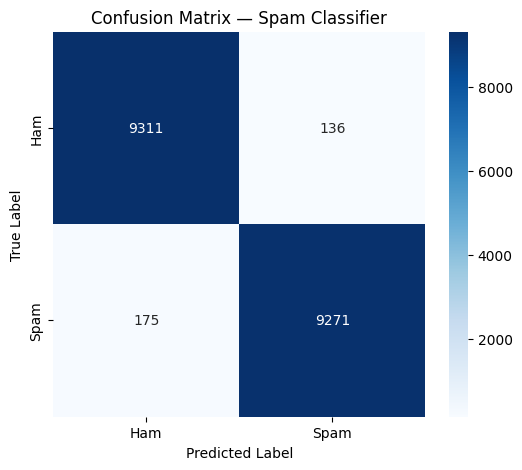

In [22]:
print("\n=== Classification report @ threshold 0.5 ===")
print(classification_report(y_true, y_pred_05, target_names=["Ham", "Spam"]))

print("\n=== Confusion matrix @ threshold 0.5 ===")
# print(confusion_matrix(y_true, y_pred_05))
cm = confusion_matrix(y_true, y_pred_05)
cm_labels = ["Ham", "Spam"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Spam Classifier")
plt.show()

In [23]:
# Define the file path where the trained encoder-based classifier will be saved
ENCODER_MODEL_PATH = "encoder_classifier.keras"
model.save(ENCODER_MODEL_PATH)

In [24]:
# Define a raw text input layer that accepts variable-length string inputs
text_input = tf.keras.Input(shape=(), dtype=tf.string, name="text")

# Use BERT preprocessor to convert raw text into structured inputs expected by the encoder
features = preproc(text_input)

# Pass the preprocessed features through the trained encoder-based classifier
# and output the predicted spam probability
probs = model(features)

In [25]:
# Create a serving-time model that accepts raw text (untokenized text) as input
serving_model = tf.keras.Model(text_input, probs, name="spam_rawtext_serving")

# Export the end-to-end model for inference to run predictions directly on raw text
serving_model.export('spam_classifier_final')

Saved artifact at 'spam_classifier_final'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='text')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132210964871504: TensorSpec(shape=(1850172,), dtype=tf.uint8, name=None)
  132210929534160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929534928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929534736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929533584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929536656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929537040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929537808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929535120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929538000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210929537616: TensorSp

In [ ]:
# Unzip end-to-end model file to be used to run predictions
!zip -r spam_classifier_final.zip spam_classifier_final

updating: spam_classifier_final/ (stored 0%)
updating: spam_classifier_final/fingerprint.pb
	zip warning: Local Entry CRC does not match CD: spam_classifier_final/fingerprint.pb
 (stored 0%)
updating: spam_classifier_final/variables/ (stored 0%)
updating: spam_classifier_final/saved_model.pb
	zip warning: Local Entry CRC does not match CD: spam_classifier_final/saved_model.pb
 (deflated 69%)
updating: spam_classifier_final/assets/ (stored 0%)
updating: spam_classifier_final/variables/variables.data-00000-of-00001
	zip warning: Local Entry CRC does not match CD: spam_classifier_final/variables/variables.data-00000-of-00001
 (deflated 7%)
updating: spam_classifier_final/variables/variables.index
	zip warning: Local Entry CRC does not match CD: spam_classifier_final/variables/variables.index
 (deflated 73%)


# End

# Sample Test Emails

In [26]:
# Long spam test email
long_email = """
Dear Valued Customer,

Congratulations! You have been selected as one of our exclusive winners in the National Online Rewards Program. Our records show that you have not yet claimed your guaranteed $10,000 cash prize. This is your FINAL opportunity to confirm your eligibility before your entry expires at midnight tonight.

To receive your reward, please verify your information immediately by clicking the secure link below. Once verified, your funds will be transferred directly to your bank account within 24 hours.

CLAIM NOW: https://secure-cashclaim-center.example.com/verify

As part of our verification process, you must confirm your personal details, including your full name, address, and banking information. This information will only be used to validate your identity and process your prize.

Failure to complete this verification step will result in the cancellation of your reward and the selection of an alternate winner.

Act fast — thousands of participants have already claimed their rewards, and our system will automatically close entries after midnight. Don’t miss out on this life-changing opportunity to receive your $10,000 reward!

Warm regards,
The National Rewards Team
support@cashreward-center.example.com

P.S. For security reasons, this message was sent only to verified email subscribers. Please do not share this link. To unsubscribe from future notifications, click here.
"""

In [27]:
# Long non-spam test email
long_email = """

Hi everyone,

I hope you’re all having a productive week so far. I wanted to send a quick update regarding our progress on the Data Integration and Reporting initiative before we meet next Tuesday. The engineering team successfully completed the migration of our reporting pipeline to the new infrastructure over the weekend. Early metrics show about a 40% improvement in query response times, which is great news.

There are still a few open issues that we’ll need to address during the next sprint. Specifically, we need to finalize the API documentation for the external partners and confirm the access permissions for the finance and analytics teams. I’ve added those items to the shared task board for visibility. Please review them before our call and leave any comments or questions directly in the tracker.

Next week’s planning session will be on Tuesday at 10 a.m. in Conference Room B (and on Zoom for remote folks). During that meeting, we’ll discuss deployment timelines, review QA results, and assign tasks for the next iteration. If you can’t make it in person, please let me know so I can ensure you have the dial-in link and the updated slide deck.

Finally, a reminder that the quarterly report drafts are due by end of day Friday. Thank you to everyone who’s already contributed data and charts; it’s made the review process much smoother. If you need any help with formatting or templates, reach out to the documentation team.

Thanks again for all the hard work this month — we’ve made solid progress and are right on track for our March release.

Best,
Alex
Project Lead, Data Systems Team

"""

In [ ]:
# Example quick test:
sample_email = """
Hi Jamie,

Just wanted to confirm we're still on for lunch tomorrow at 12.
If you need to move the time, just let me know.

Thanks,
Alex
"""